In [16]:
# Import the libraries we need for this lab

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

La clase plot_error_surfaces solo sirve para ayudarte a visualizar el espacio de datos y el espacio de parámetros durante el entrenamiento, y no tiene nada que ver con PyTorch.

In [26]:
# Create class for plotting and the function for plotting

class plot_error_surfaces(object):

    # Construstor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                yhat= 1 / (1 + np.exp(-1*(w2*self.x+b2)))
                Z[count1,count2]=-1*np.mean(self.y*np.log(yhat+1e-16) +(1-self.y)*np.log(1-yhat+1e-16))
                count2 += 1
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()

     # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)

    # Plot diagram
    def final_plot(self):
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x, self.y, 'ro', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.plot(self.x, 1 / (1 + np.exp(-1 * (self.W[-1] * self.x + self.B[-1]))), label='sigmoid')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')

# Plot the diagram

def PlotStuff(X, Y, model, epoch, leg=True):
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg == True:
        plt.legend()
    else:
        pass

Establecer la semilla aleatoria

In [27]:
# Set random seed

torch.manual_seed(0)

## Obtener algunos datos


In [28]:
# Create the data class

class Data(Dataset):

    # Constructor
    def __init__(self):
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1)
        self.y = torch.zeros(self.x.shape[0], 1)
        self.y[self.x[:, 0] > 0.2] = 1
        self.len = self.x.shape[0]

    # Getter
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # Get length
    def __len__(self):
        return self.len

Haz Data un objeto

In [29]:
# Create Data object

data_set = Data()

## Crear el modelo y la función de pérdida total


Crear un **módulo personalizado** para la **regresión logística**:


In [30]:
# Create logistic_regression class

class logistic_regression(nn.Module):

    # Constructor
    def __init__(self, n_inputs):
        super(logistic_regression, self).__init__()
        self.linear = nn.Linear(n_inputs, 1)

    # Prediction
    def forward(self, x):
        yhat = torch.sigmoid(self.linear(x))
        return yhat

Crear un **objeto o modelo de regresión logística**:


In [31]:
# Create the logistic_regression result

model = logistic_regression(1)

Reemplazar los **valores inicializados aleatoriamente**. Estos valores iniciales **no convergieron para la pérdida RMS**, pero **sí convergerán para la pérdida de entropía cruzada (*Cross-Entropy Loss*)**.


In [32]:
# Set the weight and bias

model.state_dict() ['linear.weight'].data[0] = torch.tensor([[-5]])
model.state_dict() ['linear.bias'].data[0] = torch.tensor([[-10]])
print("The parameters: ", model.state_dict())

The parameters:  OrderedDict({'linear.weight': tensor([[-5.]]), 'linear.bias': tensor([-10.])})


Crear un objeto **`plot_error_surfaces`** para visualizar el **espacio de datos** y el **espacio de parámetros** durante el entrenamiento:


<Figure size 640x480 with 0 Axes>

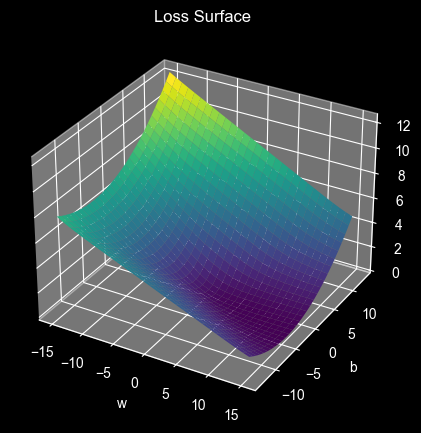

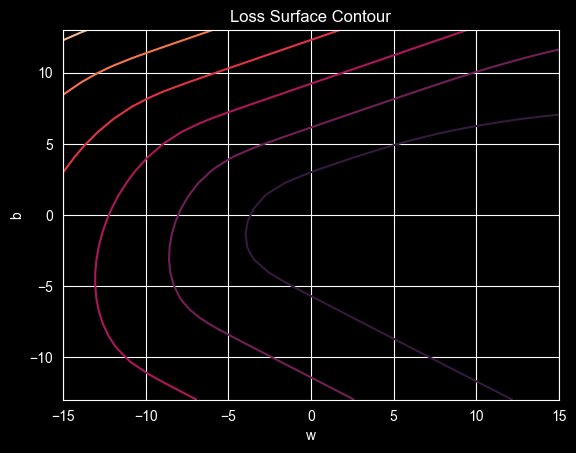

In [33]:
# Create the plot_error_surfaces object

get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

Define la función de costo

In [34]:
# Create dataloader, criterion function and optimizer

def criterion(yhat,y):
    out = -1 * torch.mean(y * torch.log(yhat) + (1 - y) * torch.log(1 - yhat))
    return out

# Build in criterion
# criterion = nn.BCELoss()

trainloader = DataLoader(dataset = data_set, batch_size = 3)
learning_rate = 2
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

Entrenar el modelo mediante **descenso de gradiente por lotes (*Batch Gradient Descent*)**


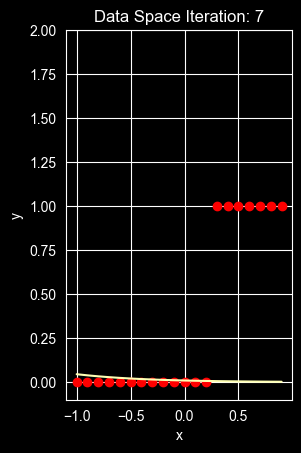

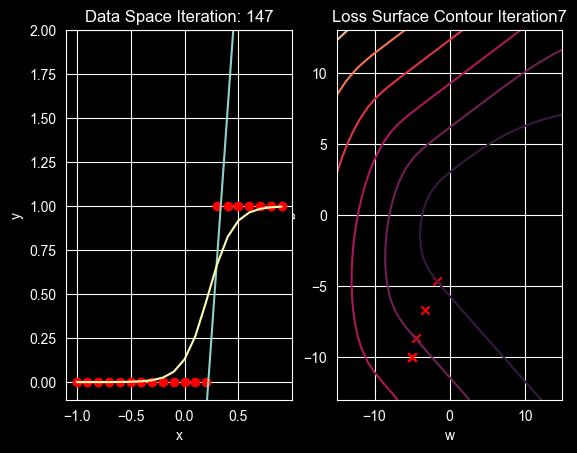

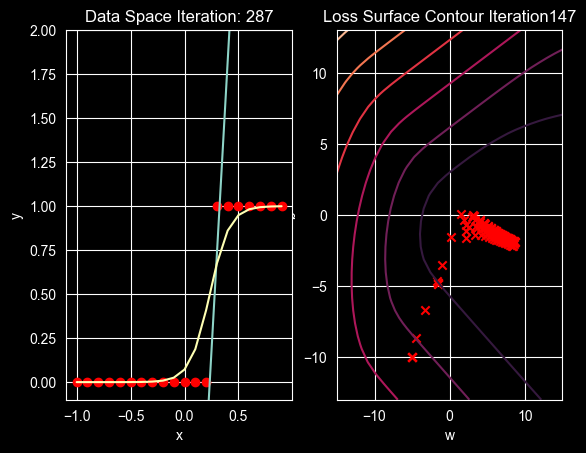

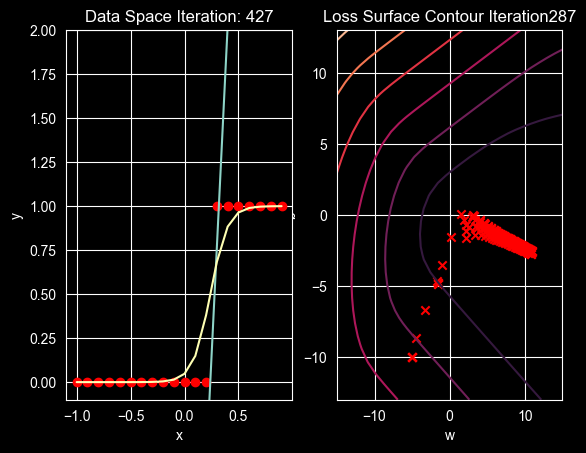

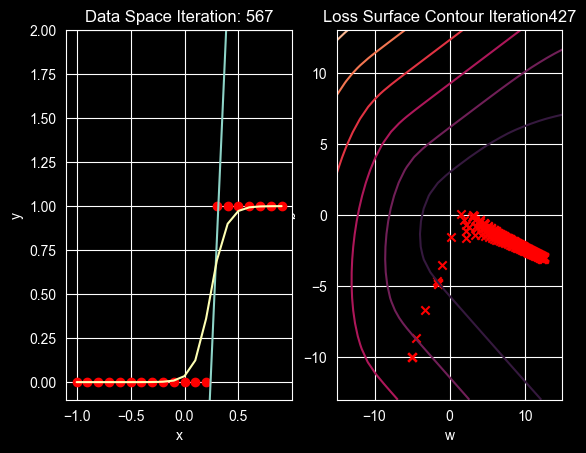

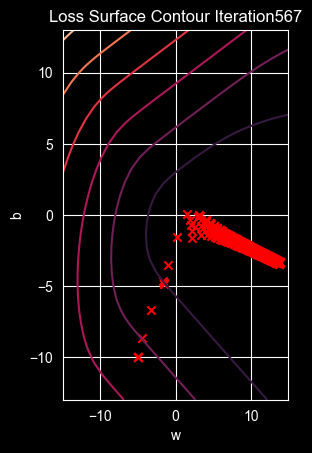

In [35]:
# Train the Model

def train_model(epochs):
    for epoch in range(epochs):
        for x, y in trainloader:
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            get_surface.set_para_loss(model, loss.tolist())
        if epoch % 20 == 0:
            get_surface.plot_ps()

train_model(100)

Obtener la **clase real de cada muestra** y **calcular la precisión (accuracy)** sobre los **datos de prueba**:


In [36]:
# Make the Prediction

yhat = model(data_set.x)
label = yhat > 0.5
print("The accuracy: ", torch.mean((label == data_set.y.type(torch.ByteTensor)).type(torch.float)))

The accuracy:  tensor(1.)


La **precisión es perfecta**.
